<h1> 
    
Proyecto Red Neuronal RNN

Fidel Alejandro Navarro Salazar

<h3> 
    
Este trabajo tiene el fin de entrenar una red neuronal tipo RNN (Recursive Neural Network) con la finalidad de realizar predicciones en base de datos secuenciales.
    

Este programa se enfocará en utilizar datos metereológicos de Australia para predecir la temperatura máxima los días posteriores. Los datos fueron tomados de Kaggle, estos pueden ser obtenidos del siguiente link
    
https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
    
    
Comenzaremos definiendo las bibliotecas y paquetes a utilizar para generar nuestra red neuronal.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

from numpy.random import seed
seed(15684)
import tensorflow
tensorflow.random.set_seed(712398)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

<h4>

Cargaremos los datos al array Aus

In [3]:
Aus = pd.DataFrame(pd.read_csv("weatherAUS.csv"))

In [4]:
Aus.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


<h4>

Podemos observar que tenemos tenemos acceso a distintas variables meterológicas para cada día, estas nos dan información de la velocidad y dirección del tiempo, humedad, presión, lluvia, temperatura máxima y mínima, entre otres.
    
Para este trabajo nos enfocaremos en predecir la temperatura máxima y mínima de cada día. Para ello nos quedaremos con las columnas de temperatura mínima, temperatura máxima, fecha y ubicación.

In [5]:
data = [Aus["Date"], Aus["Location"], Aus["MinTemp"], Aus["MaxTemp"]]
headers = ["date", "location", "minT", "maxT"]
df = pd.concat(data, axis=1, keys=headers)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      145460 non-null  object 
 1   location  145460 non-null  object 
 2   minT      143975 non-null  float64
 3   maxT      144199 non-null  float64
dtypes: float64(2), object(2)
memory usage: 4.4+ MB


<h4>
    
Del nuevo dataframe observamos que conntamos con un total de $145,460$ renglones, sin embargo no todos los valores para la termperatura máxima y mínima se encuentran disponibles. Además, es necesario cambiar el formato de la columna "date" al formato datetime.

In [7]:
df["date"] = pd.to_datetime(df["date"])
df = df.dropna()      #Eliminamos los valores NaN
df = df.reset_index() #Reacomodamos los índices

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143579 entries, 0 to 143578
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   index     143579 non-null  int64         
 1   date      143579 non-null  datetime64[ns]
 2   location  143579 non-null  object        
 3   minT      143579 non-null  float64       
 4   maxT      143579 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 5.5+ MB


<h4>
 
Debido a que la columna "location" presenta diferentes ciudades de Australia debemos de desechar todas y quedarnos con una.

In [9]:
print ("La columna location tiene", df["location"].nunique(), "diferentes ciudades.\nEstas son:")
print(df["location"].unique())

La columna location tiene 49 diferentes ciudades.
Estas son:
['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


<h4> 
    
Para elegir con cual quedarnos revisaremos cual de ellas tiene un mayor número de datos.

In [10]:
df["location"].value_counts()

Canberra            3428
Sydney              3339
Perth               3192
Hobart              3192
Darwin              3191
Adelaide            3189
Brisbane            3172
Cairns              3039
Ballarat            3038
Townsville          3037
AliceSprings        3037
Bendigo             3034
MountGambier        3034
Tuggeranong         3034
GoldCoast           3031
Launceston          3030
Wollongong          3021
Albury              3021
WaggaWagga          3009
MelbourneAirport    3009
PerthAirport        3009
Mildura             3009
SydneyAirport       3008
NorfolkIsland       3007
Moree               3007
Sale                3007
Williamtown         3004
Cobar               3003
Woomera             3002
Watsonia            3002
Penrith             3001
Portland            2999
Witchcliffe         2996
Nuriootpa           2989
CoffsHarbour        2987
Richmond            2986
PearceRAAF          2972
NorahHead           2967
BadgerysCreek       2967
Walpole             2954


<h4>

Podemos observar que la ciudad de Canberra es la que más datos tiene con un total de 3428.

In [11]:
df2 = df[df.location == "Canberra"]
df2 = df2.reset_index()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3428 entries, 0 to 3427
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   level_0   3428 non-null   int64         
 1   index     3428 non-null   int64         
 2   date      3428 non-null   datetime64[ns]
 3   location  3428 non-null   object        
 4   minT      3428 non-null   float64       
 5   maxT      3428 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 160.8+ KB


<h4>
    
Ahora si tenemos una serie de datos con la que podemos trabajar.
    
Graficaremos nuestros datos para observar su comportamiento.

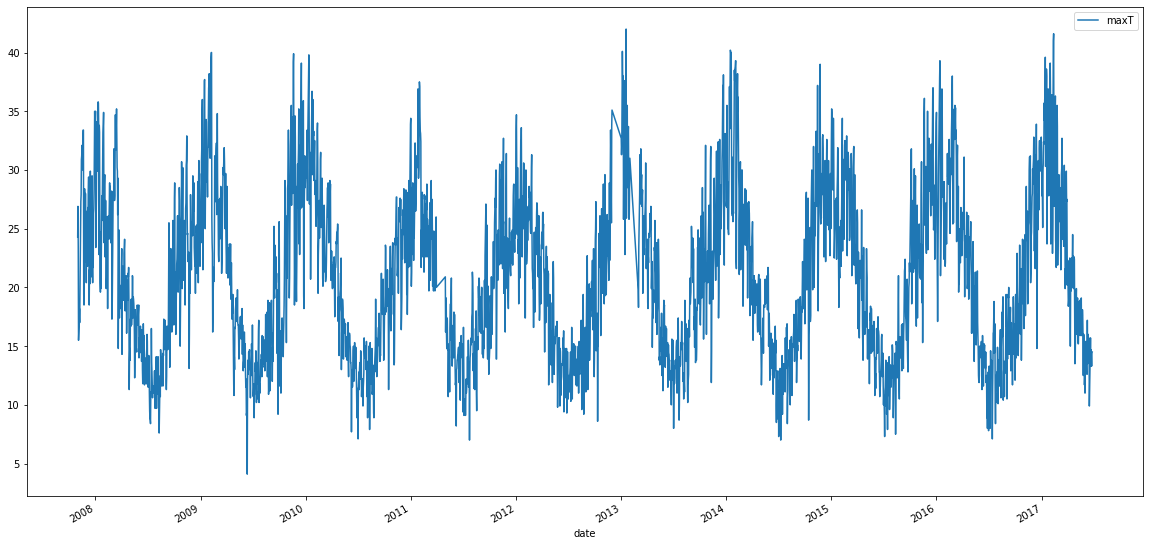

In [12]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['axes.grid'] = False

plot_cols = ["maxT"]
plot_features = df2[plot_cols]
plot_features.index = df2["date"]
plot_features.plot(subplots=True)
plt.show()

In [13]:
n_timestamp = 10
train_days = int(len(df2)*0.80) 
test_days = int(len(df2)-train_days)
epoch = 200

In [14]:
minT =[]
minT = pd.concat([df2["date"], df2["minT"]], axis=1, keys=["date", "minT"])

maxT =[]
maxT = pd.concat([df2["date"], df2["maxT"]], axis=1, keys=["date", "maxT"])

In [15]:
train_maxT = maxT[0:train_days].reset_index(drop=True)
test_maxT = maxT[train_days: test_days + train_days].reset_index(drop=True)
training_maxT = train_maxT.iloc[:, 1:2].values
testing_maxT = test_maxT.iloc[:, 1:2].values

train_minT = minT[0:train_days].reset_index(drop=True)
test_minT = minT[train_days: test_days + train_days].reset_index(drop=True)
training_minT = train_minT.iloc[:, 1:2].values
testing_minT = test_minT.iloc[:, 1:2].values

In [16]:
#Normalizamos los datos
sc = MinMaxScaler(feature_range = (0,1))
training_maxT_scaled = sc.fit_transform(training_maxT)
testing_maxT_scaled = sc.fit_transform(testing_maxT)

training_minT_scaled = sc.fit_transform(training_minT)
testing_minT_scaled = sc.fit_transform(testing_minT)

In [17]:
def data_split(sequence, n_timestampl):
    x = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [18]:
x_train, y_train = data_split(training_maxT_scaled, n_timestamp)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

x_test, y_test = data_split(testing_maxT_scaled, n_timestamp)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

x_train.shape

(2732, 10, 1)

In [19]:
#Definimos el modelo
model = Sequential()
model.add(LSTM(units = 50, activation = "relu", input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Comenzaremos el entrenamiento
model.compile(optimizer = "adam", loss = "mean_squared_error")
history = model.fit(
    x_train, y_train, epochs = epoch, batch_size = 32,
    shuffle = False, validation_data = (x_test, y_test))
loss = history.history["loss"]
val_loss = history.history['val_loss']
epochs = range(len(loss))

Epoch 1/200
86/86 [==============================] - 2s 16ms/step - loss: 0.1800 - val_loss: 0.0155
Epoch 2/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0120
Epoch 3/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0151 - val_loss: 0.0117
Epoch 4/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 5/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0143 - val_loss: 0.0117
Epoch 6/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0114
Epoch 7/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0111
Epoch 8/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0110
Epoch 9/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0108
Epoch 10/200
86/86 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 11

In [21]:
y_predicted = model.predict(x_test)
y_predicted_descaled = sc.inverse_transform(y_predicted)

y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)

y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

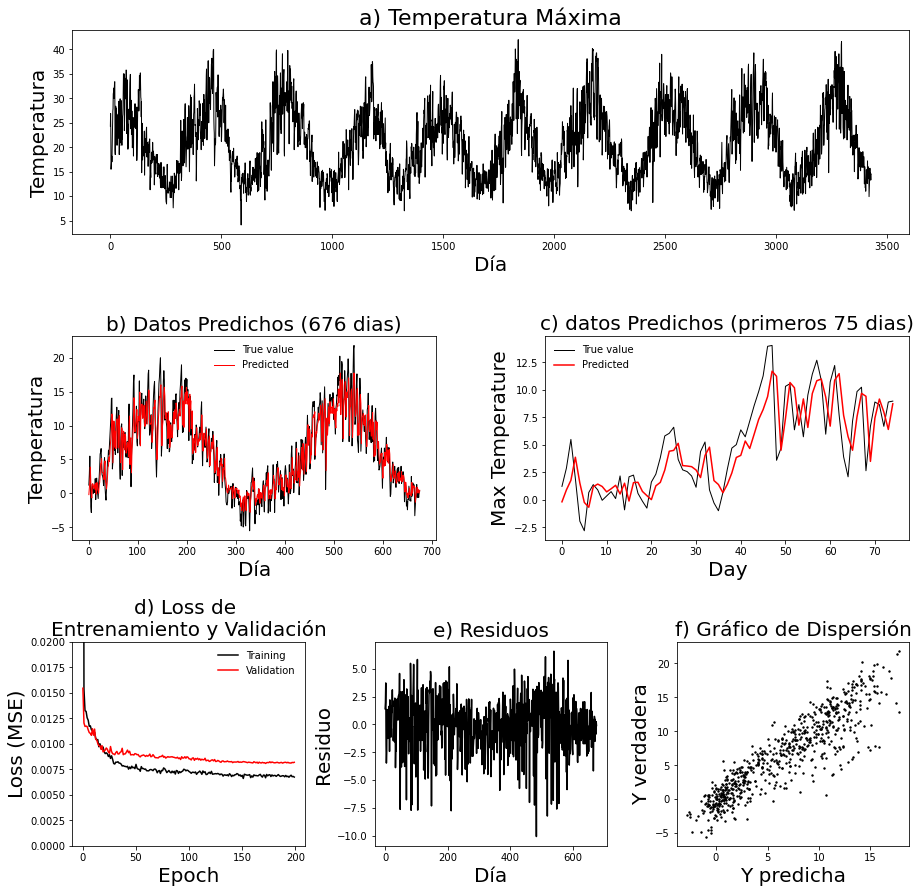

mse=6.11
r2=0.81


In [22]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.plot(df2['maxT'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Temperatura", size = 20)
plt.xlabel("Día", size = 20)
plt.title("a) Temperatura Máxima", size=22)


plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperatura", size=20)
plt.xlabel("Día", size=20)
plt.title("b) Datos Predichos ("+str(len(x_test))+" dias)", size=20)

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:75], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:75], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Max Temperature", size=20)
plt.xlabel("Day", size=20)
plt.title("c) datos Predichos (primeros 75 dias)", size=20)

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black', label = "Training")
plt.plot(epochs, val_loss, color='red', label = "Validation")
plt.legend(frameon=False)
plt.ylabel("Loss (MSE)", size=20)
plt.xlabel("Epoch", size=20)
plt.title("d) Loss de \nEntrenamiento y Validación", size=20)
plt.ylim([0,0.02])

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residuo", size = 20)
plt.xlabel("Día", size=20)
plt.title("e) Residuos", size=20)

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y verdadera", size =20)
plt.xlabel("Y predicha", size=20)
plt.title("f) Gráfico de Dispersión", size=20)

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))